# Loan Approval Analysis Explainable AI

This project analyzes loan approval decisions using Logistic Regression and Random Forest models, with a focus on:

- Predictive performance
- Feature importance analysis
- Fairness evaluation across education levels

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import partial_dependence, PartialDependenceDisplay

## Loading and Preprocessing the Data

In [7]:
df = pd.read_csv('df1_loan.csv')

Data Cleaning includes:

- Missing categorical values (e.g., Gender, Married) are filled with the mode (most frequent value).
- Missing numerical values (e.g., LoanAmount, Credit_History) are filled with median or mode.
- The Total_Income column is cleaned by removing currency symbols and converted to float.

In [8]:
# Drop unnecessary index column
df.drop(['Unnamed: 0'], axis=1, inplace=True)

# Fill missing categorical values with mode (most frequent value)
for col in ['Gender', 'Married', 'Dependents', 'Self_Employed']:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Fill missing numerical values
df['LoanAmount'].fillna(df['LoanAmount'].median(), inplace=True)
df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mode()[0], inplace=True)
df['Credit_History'].fillna(df['Credit_History'].mode()[0], inplace=True)

# Clean and convert Total_Income from string to float
df['Total_Income'] = df['Total_Income'].replace('[\$,]', '', regex=True).astype(float)

# Encode categorical variables as numerical values
df['Loan_Status'] = df['Loan_Status'].map({'Y': 1, 'N': 0})  # Loan approval status
df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})
df['Married'] = df['Married'].map({'Yes': 1, 'No': 0})
df['Self_Employed'] = df['Self_Employed'].map({'Yes': 1, 'No': 0})
df['Dependents'] = df['Dependents'].replace('3+', '3').astype(int)

# Save original Education values before encoding
df['Education_Original'] = df['Education']
df['Education'] = df['Education'].map({'Graduate': 1, 'Not Graduate': 0})

<>:14: SyntaxWarning: invalid escape sequence '\$'
<>:14: SyntaxWarning: invalid escape sequence '\$'
C:\Users\milto\AppData\Local\Temp\ipykernel_10192\3754290371.py:14: SyntaxWarning: invalid escape sequence '\$'
  df['Total_Income'] = df['Total_Income'].replace('[\$,]', '', regex=True).astype(float)
C:\Users\milto\AppData\Local\Temp\ipykernel_10192\3754290371.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)
C:\Users\milto\AppData\Local\Temp\ipykernel_10192\3754290371.py:9: F

In [9]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Total_Income,Education_Original
0,LP001002,1,0,0,1,0,5849,0.0,126.5,360.0,1.0,Urban,1,5849.0,Graduate
1,LP001003,1,1,1,1,0,4583,1508.0,128.0,360.0,1.0,Rural,0,6091.0,Graduate
2,LP001005,1,1,0,1,1,3000,0.0,66.0,360.0,1.0,Urban,1,3000.0,Graduate
3,LP001006,1,1,0,0,0,2583,2358.0,120.0,360.0,1.0,Urban,1,4941.0,Not Graduate
4,LP001008,1,0,0,1,0,6000,0.0,141.0,360.0,1.0,Urban,1,6000.0,Graduate


## Feature Engineering

This includes:
- One-hot encoding for categorical variables (Education, Property_Area)
- Feature engineering: income per dependent, EMI calculation, and balance income
- Log transformation of skewed numerical features

In [10]:
# One-hot encode Property_Area
df = pd.get_dummies(df, columns=['Property_Area'], drop_first=True)

# Feature engineering - create new features
df['Income_per_dependent'] = df['Total_Income'] / (df['Dependents'] + 1)
df['EMI'] = df['LoanAmount'] / df['Loan_Amount_Term']
df['Balance_Income'] = df['Total_Income'] - (df['EMI'] * 1000)

# Log transform skewed numerical features
df['LoanAmount_Log'] = np.log(df['LoanAmount'])
df['Total_Income_Log'] = np.log(df['Total_Income'])

## Model Building and Model Evaluation

- Logistic Regression: With standardized features for better performance
- Random Forest: Without standardization (tree-based models don't require it)

In [11]:
# Split features and target
X = df.drop(['Loan_Status', 'Education_Original', 'Loan_ID'], axis=1)
y = df['Loan_Status']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling for Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled arrays back to DataFrames for interpretability
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [12]:
# Train Logistic Regression model
print("Training Logistic Regression Model...")
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

# Train Random Forest model
print("Training Random Forest Model...")
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

Training Logistic Regression Model...
Training Random Forest Model...


RandomForestClassifier(random_state=42)

## Feature Importance Analysis


=== Feature Importance Comparison ===


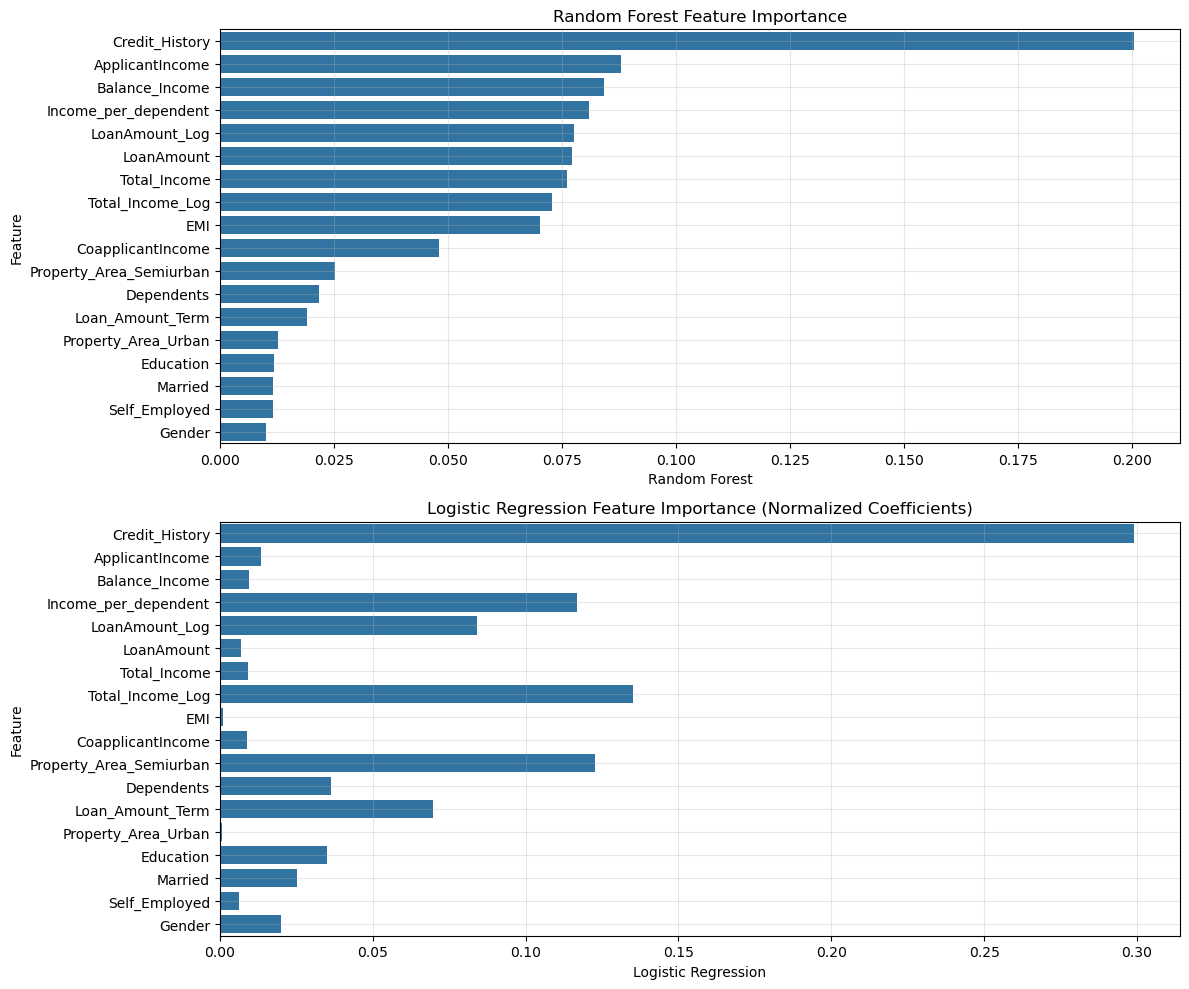

Top 5 Features by Random Forest:
                 Feature  Logistic Regression  Random Forest
9         Credit_History             0.299089       0.200576
5        ApplicantIncome             0.013572       0.088047
15        Balance_Income             0.009423       0.084272
13  Income_per_dependent             0.116920       0.081051
16        LoanAmount_Log             0.084163       0.077599


In [13]:
print("\n=== Feature Importance Comparison ===")

# Get and normalize Logistic Regression coefficients
lr_coef = lr_model.coef_[0]
lr_importance = abs(lr_coef) / sum(abs(lr_coef))

# Get Random Forest feature importances
rf_importance = rf_model.feature_importances_

# Create DataFrame for comparison
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Logistic Regression': lr_importance,
    'Random Forest': rf_importance
}).sort_values('Random Forest', ascending=False)

# Plot feature importance comparison
plt.figure(figsize=(12, 10))

# Random Forest importance plot
plt.subplot(2, 1, 1)
sns.barplot(x='Random Forest', y='Feature', data=importance_df)
plt.title('Random Forest Feature Importance')
plt.grid(True, alpha=0.3)

# Logistic Regression importance plot
plt.subplot(2, 1, 2)
sns.barplot(x='Logistic Regression', y='Feature', data=importance_df)
plt.title('Logistic Regression Feature Importance (Normalized Coefficients)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Show top features
print("Top 5 Features by Random Forest:")
print(importance_df.head(5))

### Interpretation:

- Credit_History is the most important feature for both models, but its dominance is stronger in Logistic Regression (30% contribution) compared to Random Forest (20%). Implication: A good credit history significantly increases loan approval chances, especially for Logistic Regression.

- ApplicantIncome, Balance_Income, and Income_per_dependent are more influential in Random Forest than Logistic Regression. Implication: Random Forest captures non-linear relationships between income-related features and approval, while Logistic Regression relies more on linear effects (e.g., credit history).

- LoanAmount_Log has moderate importance in both models. Implication: Larger loan amounts slightly reduce approval odds (log-transform mitigates skewness).

## Partial Dependence Plots (PDPs)

This includes: 

- Continuous Features: LoanAmount_Log and Total_Income_Log are analyzed to show their marginal effect on loan approval probability.
- Binary Features: Credit_History, Gender, and Education are analyzed by comparing average approval probabilities for each value (0 or 1).


=== Partial Dependence Plots ===
Creating PDP plots for continuous features (Logistic Regression)...


C:\Users\milto\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\milto\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\milto\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\milto\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\milto\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\milto\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2732: Use

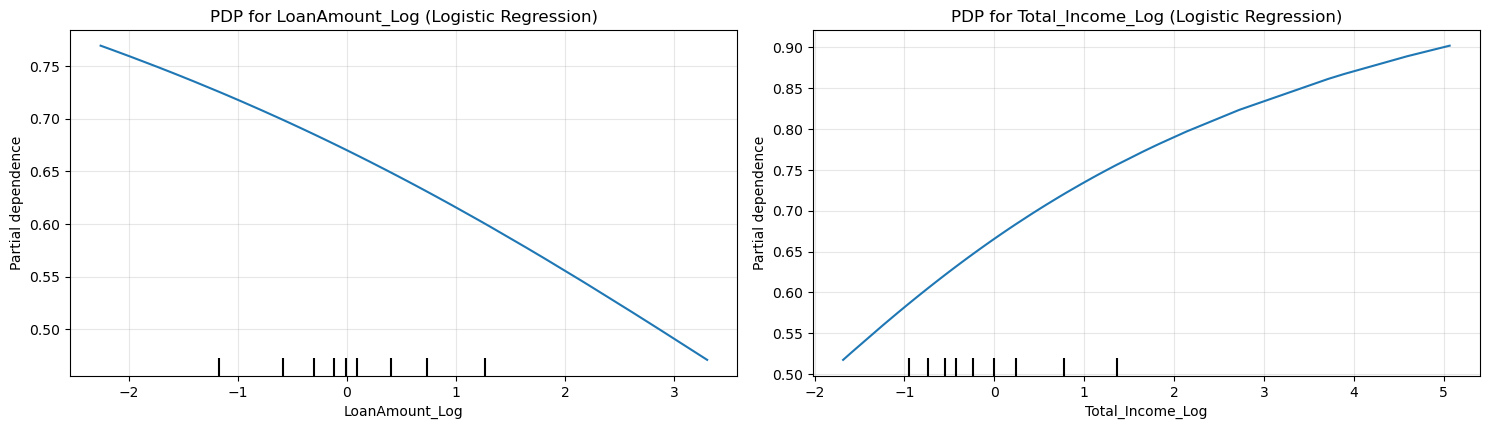

Creating PDP plots for binary features (Logistic Regression)...


C:\Users\milto\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\milto\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\milto\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\milto\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\milto\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\milto\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2732: Use

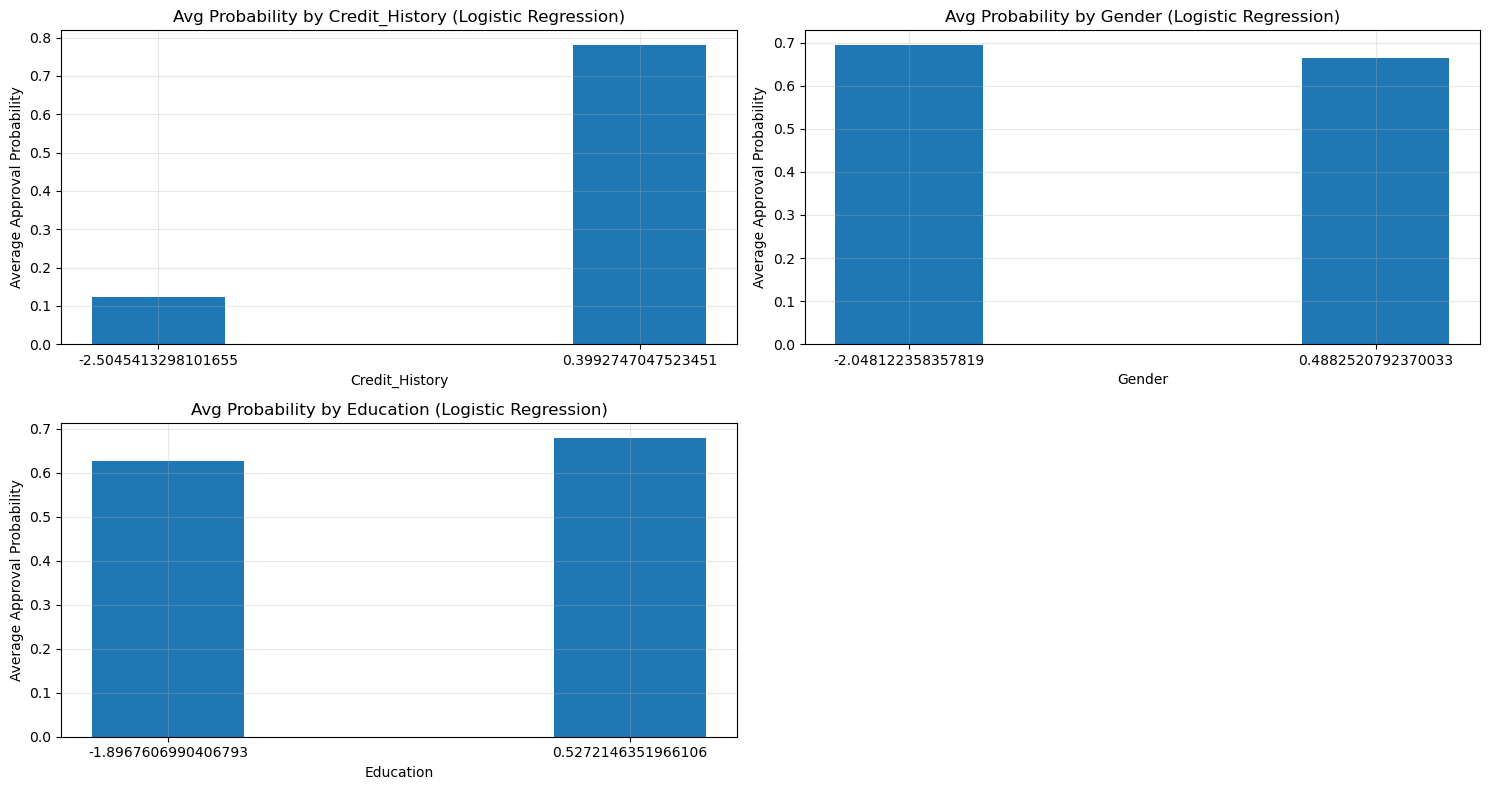

Creating PDP plots for continuous features (Random Forest)...


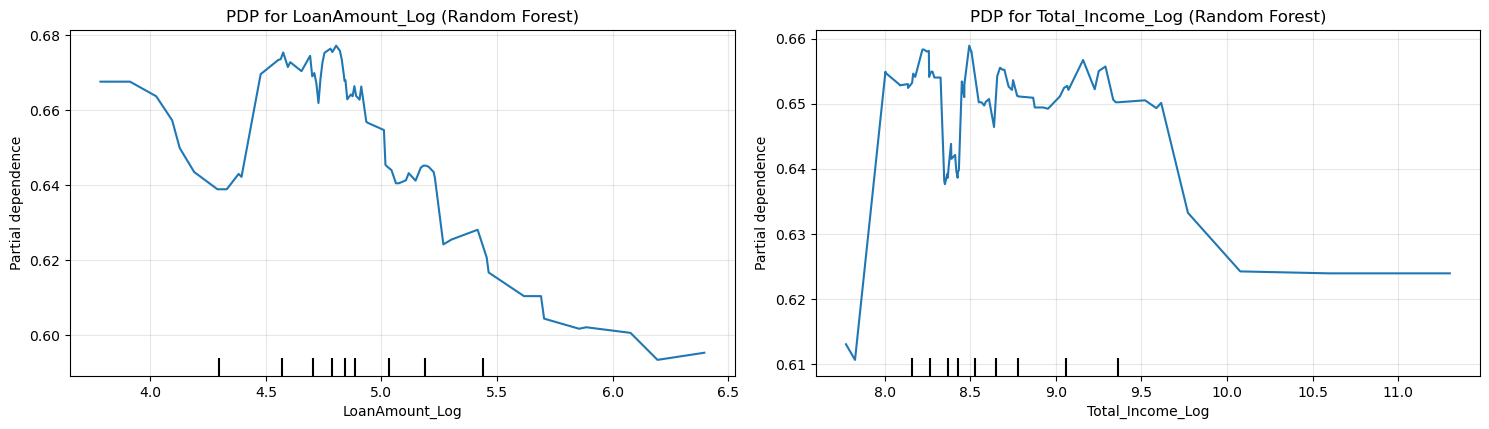

Creating PDP plots for binary features (Random Forest)...


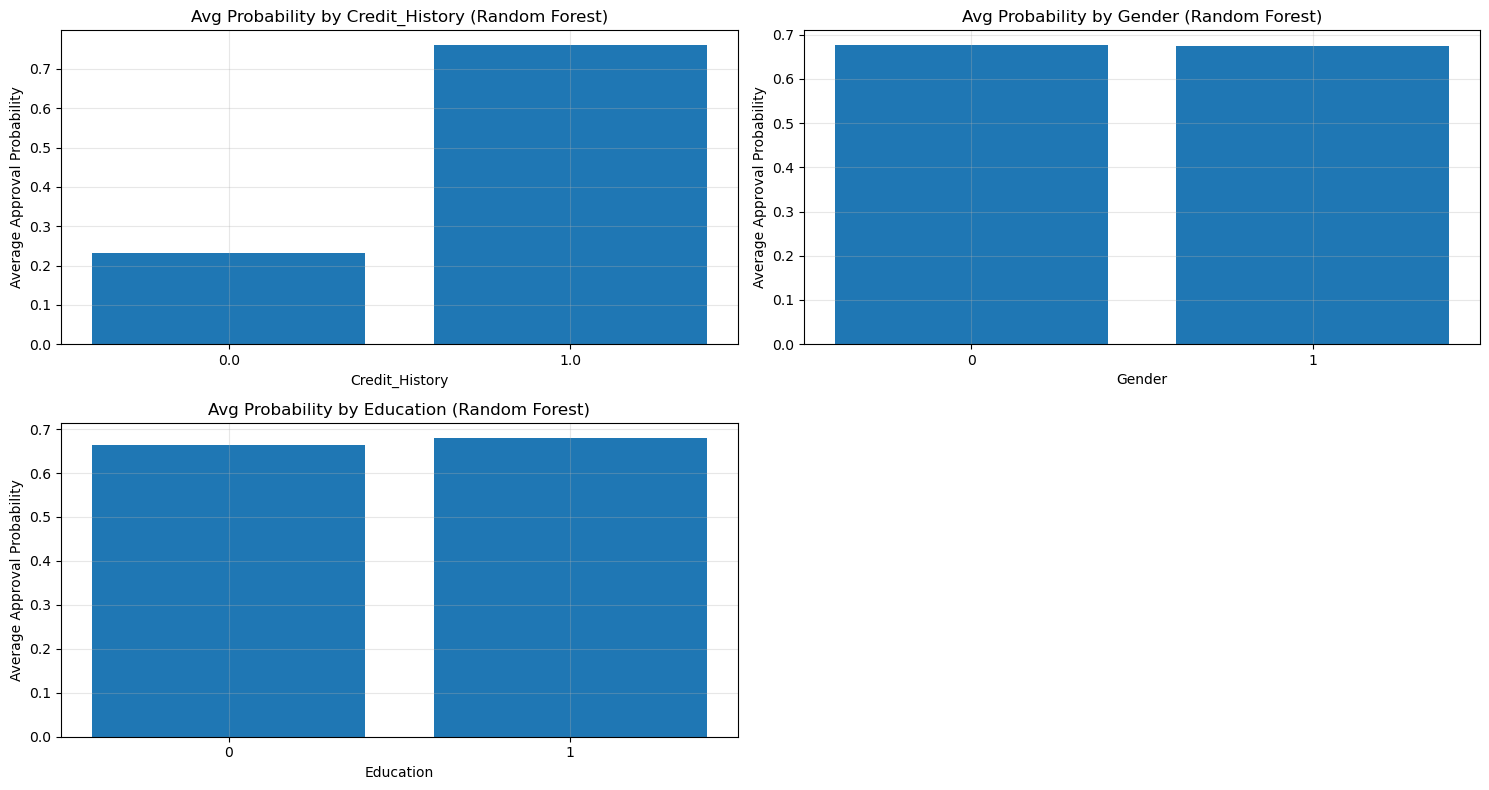

In [14]:
print("\n=== Partial Dependence Plots ===")
# Separate continuous and binary features
continuous_features = ['LoanAmount_Log', 'Total_Income_Log']
binary_features = ['Credit_History', 'Gender', 'Education']

# For Logistic Regression - Continuous Features
print("Creating PDP plots for continuous features (Logistic Regression)...")
plt.figure(figsize=(15, 8))
for i, feature in enumerate(continuous_features):
    plt.subplot(2, 2, i+1)
    
    # Use PartialDependenceDisplay which handles the reshaping automatically
    PartialDependenceDisplay.from_estimator(
        lr_model,
        X_test_scaled_df,
        [feature],
        kind="average",
        ax=plt.gca(),
        random_state=42
    )
    plt.title(f'PDP for {feature} (Logistic Regression)')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# For Logistic Regression - Binary Features
print("Creating PDP plots for binary features (Logistic Regression)...")
plt.figure(figsize=(15, 8))
for i, feature in enumerate(binary_features):
    plt.subplot(2, 2, i+1)
    
    # For binary features, we'll manually calculate the average predictions
    unique_vals = sorted(X_test_scaled_df[feature].unique())
    avg_probs = []
    
    for val in unique_vals:
        temp_df = X_test_scaled_df.copy()
        temp_df[feature] = val
        avg_probs.append(lr_model.predict_proba(temp_df)[:, 1].mean())
    
    plt.bar(unique_vals, avg_probs)
    plt.xticks(unique_vals, [str(v) for v in unique_vals])
    plt.title(f'Avg Probability by {feature} (Logistic Regression)')
    plt.xlabel(feature)
    plt.ylabel('Average Approval Probability')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# For Random Forest - Continuous Features
print("Creating PDP plots for continuous features (Random Forest)...")
plt.figure(figsize=(15, 8))
for i, feature in enumerate(continuous_features):
    plt.subplot(2, 2, i+1)
    
    PartialDependenceDisplay.from_estimator(
        rf_model,
        X_test,
        [feature],
        kind="average",
        ax=plt.gca(),
        random_state=42
    )
    plt.title(f'PDP for {feature} (Random Forest)')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# For Random Forest - Binary Features
print("Creating PDP plots for binary features (Random Forest)...")
plt.figure(figsize=(15, 8))
for i, feature in enumerate(binary_features):
    plt.subplot(2, 2, i+1)
    
    unique_vals = sorted(X_test[feature].unique())
    avg_probs = []
    
    for val in unique_vals:
        temp_df = X_test.copy()
        temp_df[feature] = val
        avg_probs.append(rf_model.predict_proba(temp_df)[:, 1].mean())
    
    plt.bar(unique_vals, avg_probs)
    plt.xticks(unique_vals, [str(v) for v in unique_vals])
    plt.title(f'Avg Probability by {feature} (Random Forest)')
    plt.xlabel(feature)
    plt.ylabel('Average Approval Probability')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Individual Conditional Expectation (ICE) Plots

LoanAmount Analysis: ICE plots show how individual predictions vary with LoanAmount_Log for both models.

- Each line represents a single observation's predicted probability as LoanAmount_Log changes.
- This helps visualize heterogeneity in model predictions.


=== Individual Conditional Expectation Plots ===
Creating ICE plot for LoanAmount with Logistic Regression...


C:\Users\milto\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\milto\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\milto\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\milto\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\milto\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\milto\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2732: Use

<Figure size 1000x600 with 0 Axes>

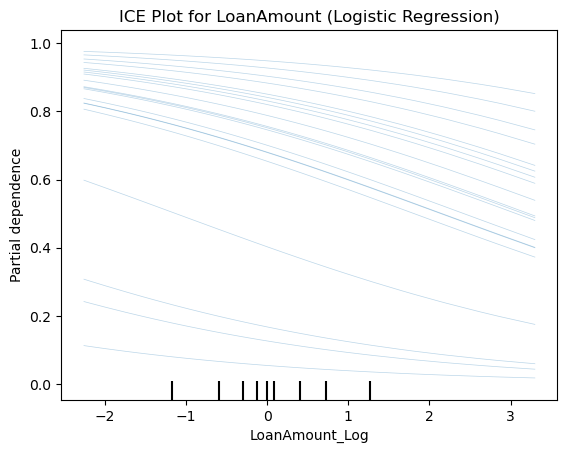

Creating ICE plot for LoanAmount with Random Forest...


<Figure size 1000x600 with 0 Axes>

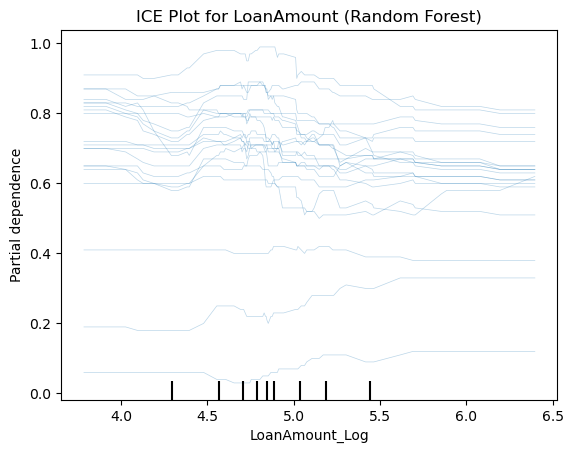

In [15]:
print("\n=== Individual Conditional Expectation Plots ===")

# For Logistic Regression
print("Creating ICE plot for LoanAmount with Logistic Regression...")
plt.figure(figsize=(10, 6))
PartialDependenceDisplay.from_estimator(
    lr_model, 
    X_test_scaled_df, 
    ['LoanAmount_Log'], 
    kind="individual", 
    subsample=20
)
plt.title('ICE Plot for LoanAmount (Logistic Regression)')
plt.show()

# For Random Forest
print("Creating ICE plot for LoanAmount with Random Forest...")
plt.figure(figsize=(10, 6))
PartialDependenceDisplay.from_estimator(
    rf_model, 
    X_test, 
    ['LoanAmount_Log'], 
    kind="individual", 
    subsample=20
)
plt.title('ICE Plot for LoanAmount (Random Forest)')
plt.show()


## Education and Income Impact Analysis

A plot shows how the predicted probability of approval varies with Total_Income for graduates vs. non-graduates.


=== Education and Income Impact Analysis ===
Analyzing how education level impacts predictions (Logistic Regression)...


C:\Users\milto\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\milto\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\milto\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\milto\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\milto\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\milto\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2732: Use

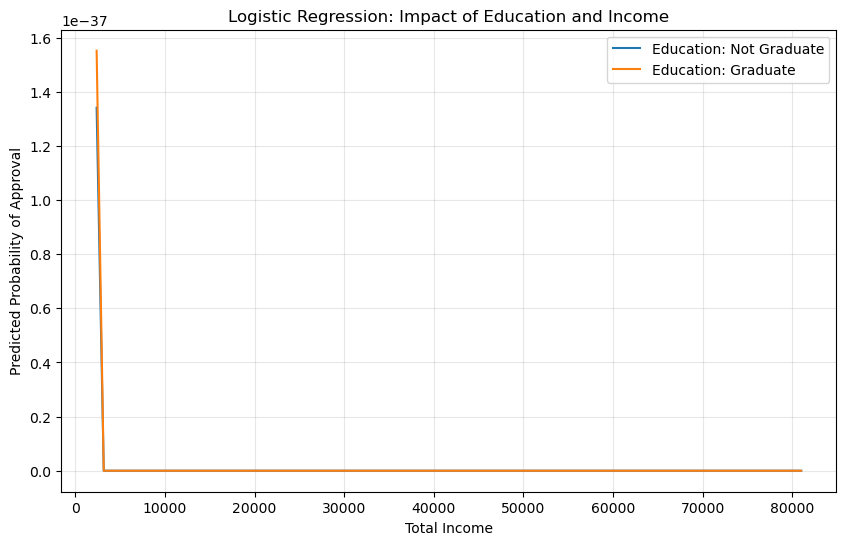

Analyzing how education level impacts predictions (Random Forest)...


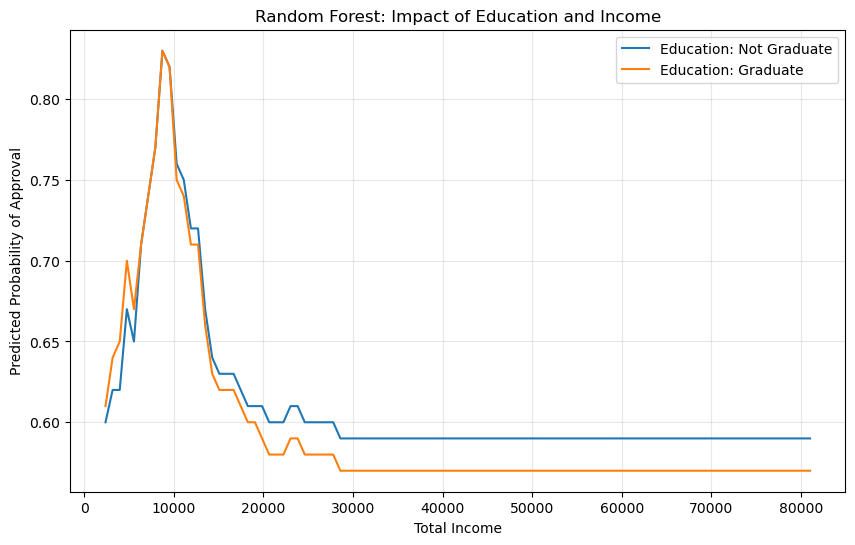

In [16]:
print("\n=== Education and Income Impact Analysis ===")

# For Logistic Regression
print("Analyzing how education level impacts predictions (Logistic Regression)...")
plt.figure(figsize=(10, 6))
income_values = np.linspace(X_test['Total_Income'].min(), X_test['Total_Income'].max(), 100)

for edu_val, edu_label in zip([0, 1], ['Not Graduate', 'Graduate']):
    predictions = []
    for income in income_values:
        sample = X_test_scaled_df.iloc[0:1].copy()
        sample['Education'] = edu_val
        sample['Total_Income'] = income
        sample['Total_Income_Log'] = np.log(income)
        pred = lr_model.predict_proba(sample)[0, 1]
        predictions.append(pred)
    plt.plot(income_values, predictions, label=f'Education: {edu_label}')

plt.xlabel('Total Income')
plt.ylabel('Predicted Probability of Approval')
plt.title('Logistic Regression: Impact of Education and Income')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# For Random Forest (similar process but with unscaled data)
print("Analyzing how education level impacts predictions (Random Forest)...")
plt.figure(figsize=(10, 6))
for edu_val, edu_label in zip([0, 1], ['Not Graduate', 'Graduate']):
    predictions = []
    for income in income_values:
        sample = X_test.iloc[0:1].copy()
        sample['Education'] = edu_val
        sample['Total_Income'] = income
        sample['Total_Income_Log'] = np.log(income)
        pred = rf_model.predict_proba(sample)[0, 1]
        predictions.append(pred)
    plt.plot(income_values, predictions, label=f'Education: {edu_label}')

plt.xlabel('Total Income')
plt.ylabel('Predicted Probability of Approval')
plt.title('Random Forest: Impact of Education and Income')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Fairness Analysis by Education Level

**Metrics Calculated**

- Selection Rate: Proportion of applicants approved in each education group.
- True Positive Rate (TPR): Proportion of correctly approved applicants.
- False Positive Rate (FPR): Proportion of incorrectly approved applicants.

**Fairness Metrics**

- Demographic Parity Difference: Difference in selection rates between groups.
- Equal Opportunity Difference: Difference in TPR between groups.
- Visualization: Bar plots compare these metrics for graduates vs. non-graduates for both models.


=== Fairness Analysis by Education Level ===
Fairness metrics for Logistic Regression:


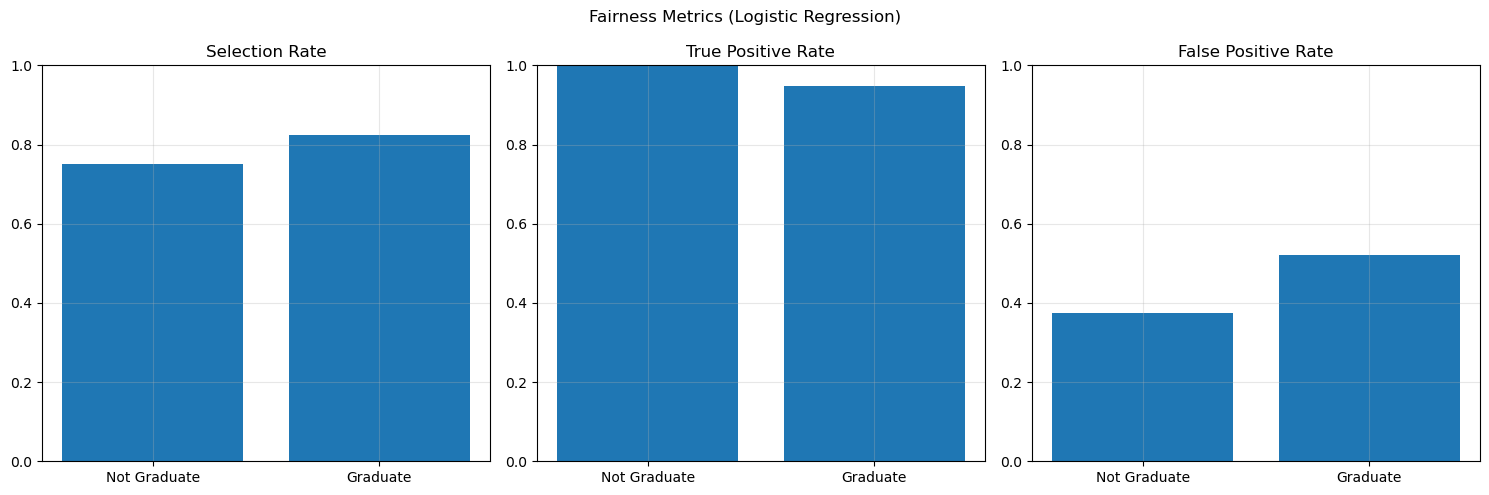


=== Education Fairness Metrics for Logistic Regression ===
Demographic Parity Difference: 0.0750
Demographic Parity Ratio: 0.9091
Equal Opportunity Difference: 0.0526
Equal Opportunity Ratio: 0.9474

Fairness metrics for Random Forest:


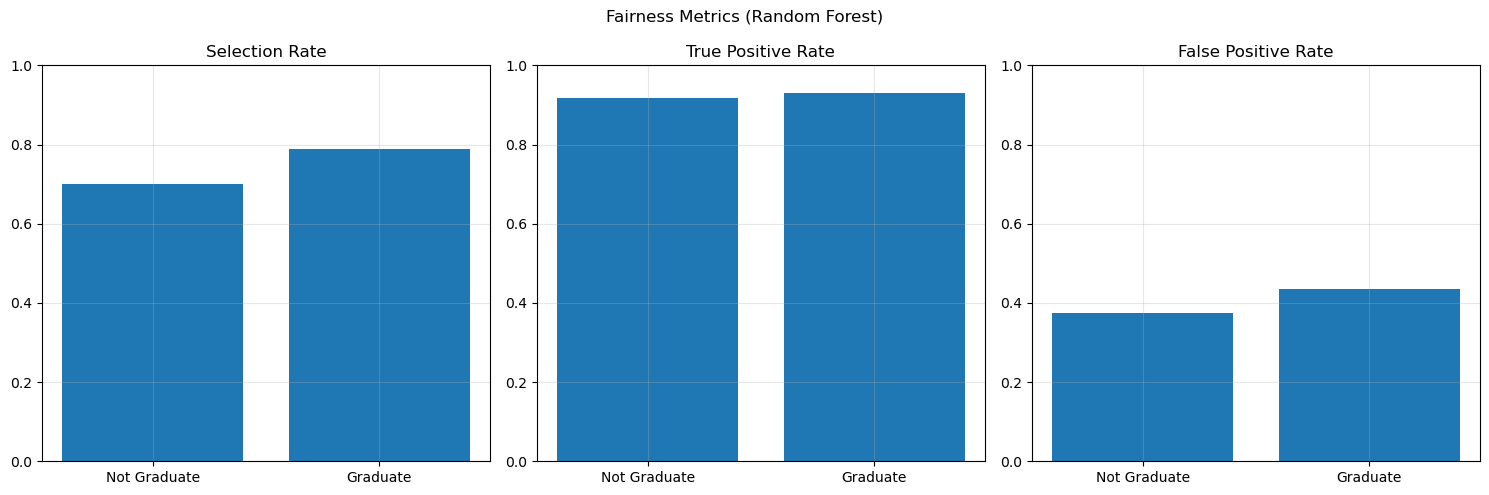


=== Education Fairness Metrics for Random Forest ===
Demographic Parity Difference: 0.0875
Demographic Parity Ratio: 0.8889
Equal Opportunity Difference: 0.0132
Equal Opportunity Ratio: 0.9858


In [17]:
print("\n=== Fairness Analysis by Education Level ===")

def calculate_fairness_metrics(model, X_test, y_test, model_name, scaled=False):
    """Helper function to calculate and display fairness metrics"""
    y_pred = model.predict(X_test_scaled if scaled else X_test)
    education = X_test['Education'].values
    
    # Initialize metric storage
    metrics = {
        'Selection Rate': [],
        'True Positive Rate': [],
        'False Positive Rate': []
    }
    
    # Calculate metrics for each education group
    for edu_val in [0, 1]:
        mask = education == edu_val
        y_test_sub = y_test.values[mask]
        y_pred_sub = y_pred[mask]
        
        metrics['Selection Rate'].append(np.mean(y_pred_sub))
        
        # True Positive Rate (TPR)
        if sum(y_test_sub == 1) > 0:
            tpr = sum((y_pred_sub == 1) & (y_test_sub == 1)) / sum(y_test_sub == 1)
        else:
            tpr = 0
        metrics['True Positive Rate'].append(tpr)
        
        # False Positive Rate (FPR)
        if sum(y_test_sub == 0) > 0:
            fpr = sum((y_pred_sub == 1) & (y_test_sub == 0)) / sum(y_test_sub == 0)
        else:
            fpr = 0
        metrics['False Positive Rate'].append(fpr)
    
    # Plot metrics
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for i, (metric, values) in enumerate(metrics.items()):
        axes[i].bar(['Not Graduate', 'Graduate'], values)
        axes[i].set_title(metric)
        axes[i].set_ylim(0, 1)
        axes[i].grid(True, alpha=0.3)
    
    plt.suptitle(f'Fairness Metrics ({model_name})')
    plt.tight_layout()
    plt.show()
    
    # Calculate and print fairness metrics
    dp_diff = abs(metrics['Selection Rate'][0] - metrics['Selection Rate'][1])
    dp_ratio = min(metrics['Selection Rate']) / max(metrics['Selection Rate']) if max(metrics['Selection Rate']) > 0 else 1
    
    tpr_diff = abs(metrics['True Positive Rate'][0] - metrics['True Positive Rate'][1])
    tpr_ratio = min(metrics['True Positive Rate']) / max(metrics['True Positive Rate']) if max(metrics['True Positive Rate']) > 0 else 1
    
    print(f"\n=== Education Fairness Metrics for {model_name} ===")
    print(f"Demographic Parity Difference: {dp_diff:.4f}")
    print(f"Demographic Parity Ratio: {dp_ratio:.4f}")
    print(f"Equal Opportunity Difference: {tpr_diff:.4f}")
    print(f"Equal Opportunity Ratio: {tpr_ratio:.4f}")

# Analyze Logistic Regression
print("Fairness metrics for Logistic Regression:")
calculate_fairness_metrics(lr_model, X_test, y_test, "Logistic Regression", scaled=True)

# Analyze Random Forest
print("\nFairness metrics for Random Forest:")
calculate_fairness_metrics(rf_model, X_test, y_test, "Random Forest", scaled=False)

### Interpretation of Fairness Metrics for Logistic Regression

The bias is minor but statistically present. Investigate whether this reflects legitimate risk differences or unfair bias (e.g., non-graduates might have lower incomes, which the model already accounts for).

#### Key Findings

**Demographic Parity (Selection Rate Fairness)**:
- Difference: Graduates are approved 7.5% more often than non-graduates.
- Ratio: Non-graduates receive 90.9% of the approvals that graduates do.
- Implication: Small but measurable bias favoring graduates.

**Equal Opportunity (TPR Fairness)**:
- Difference: Graduates who should be approved (true positives) are approved 5.26% more often.
- Ratio: Non-graduates’ true approval rate is 94.7% of graduates’.
- Implication: The model is slightly better at correctly approving graduates.

### Interpretation of Fairness Fairness Metrics for Random Forest

Random Forest’s true approval rates (Equal Opportunity) are nearly equal, but its overall approval rates (Demographic Parity) are less fair.

#### Key Findings

**Demographic Parity (Selection Rate Fairness)**:
- Difference: Graduates are approved 8.75% more often—slightly worse than Logistic Regression.
- Ratio: Non-graduates receive 88.9% of the approvals.

**Equal Opportunity (TPR Fairness)**:
- Difference: Only 1.32% gap in TPR (much better than Logistic Regression).
- Ratio: 98.6% parity in true approvals.
- Implication: Random Forest is fairer in outcomes (similar TPR) but less fair in selection rates.

## Conclusion

While both models perform well, the choice between them depends on the prioritization of fairness metrics (equal opportunity vs. demographic parity) and interpretability. This analysis provides a framework for ethical AI deployment in lending, balancing predictive power with equitable outcomes.

### Key Findings

#### 1. Critical Drivers of Approval:
- Credit History emerged as the most influential feature for both models, underscoring its role in risk assessment.
- Income-related features (e.g., Balance_Income, Income_per_dependent) were more significant in the Random Forest model, highlighting its ability to capture non-linear relationships.

#### 2. Model Performance and Fairness Trade-offs:
- Logistic Regression exhibited stronger bias in equal opportunity (5.26% approval gap for qualified applicants) but slightly better demographic parity (7.5% gap in overall approvals).
- Random Forest reduced equal opportunity bias to 1.32% (fairer outcomes for qualified applicants) but had worse demographic parity (8.75% gap), suggesting it may over-approve marginally qualified graduates.

#### 2. Fairness Insights:
- Both models showed modest bias favoring graduates, though the disparities were relatively small.
- Random Forest’s near-perfect equal opportunity ratio (98.6%) makes it preferable if the goal is to minimize missed approvals for deserving applicants, while Logistic Regression may be more suitable if equal approval rates are prioritized.